In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np

In [2]:
folder = '../data/interim/S1AvsAR_15May2025/'

In [3]:
seq_lens = []
for record in SeqIO.parse(folder + 'reads.fasta', 'fasta'):
    seq_lens.append(len(record.seq))

In [70]:
len(seq_lens)

81221

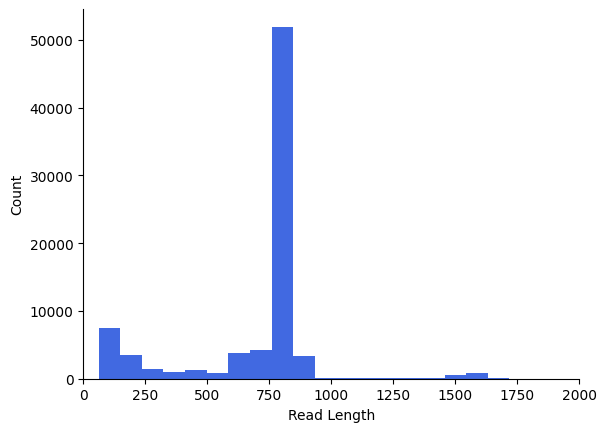

In [4]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(seq_lens, bins=50, facecolor='royalblue')
plt.xlim([0, 2000])
plt.xlabel('Read Length')
plt.ylabel('Count')

plt.show()

In [5]:
counts_in = pd.read_csv(folder + 'input_counts.txt', sep='\t', header=None)
counts_out = pd.read_csv(folder + 'output_counts.txt', sep='\t', header=None)

counts_in.columns = ['seq_id', 'read_count']
counts_out.columns = ['seq_id', 'read_count']

#counts_in = counts_in.query('read_count > 100')
#counts_out = counts_out.query('read_count > 100')

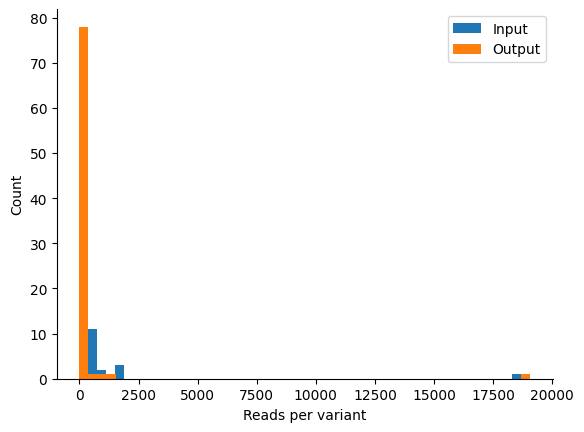

In [6]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(counts_in.read_count, bins=50, label='Input')
plt.hist(counts_out.read_count, bins=50, label='Output')
plt.xlabel('Reads per variant')
plt.ylabel('Count')

plt.legend()

plt.show()

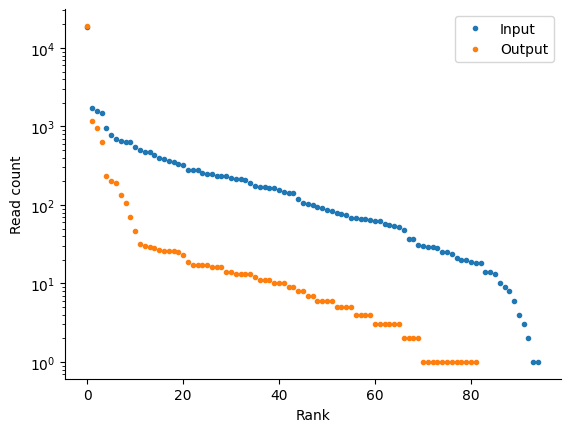

In [7]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(counts_in.read_count.sort_values(ascending=False), '.', label='Input')
plt.plot(counts_out.read_count.sort_values(ascending=False), '.', label='Output')

plt.yscale('log')

plt.xlabel('Rank')
plt.ylabel('Read count')

plt.legend()

plt.show()

In [31]:
def bootstrap_enrichment_single_counts(input_counts, output_counts, B=1000, pseudocount=1):
    input_counts = np.array(input_counts)
    output_counts = np.array(output_counts)

    # Normalize to get probabilities
    input_total = input_counts.sum()
    output_total = output_counts.sum()

    input_freqs = input_counts / input_total
    output_freqs = output_counts / output_total

    n_variants = len(input_counts)
    enrichments = np.zeros(n_variants)
    errors = np.zeros(n_variants)

    boot_matrix = []

    for _ in range(B):
        input_boot = np.random.multinomial(input_total, input_freqs)
        output_boot = np.random.multinomial(output_total, output_freqs)

        enrichment_boot = np.log((output_boot + pseudocount) / (input_boot + pseudocount))
        boot_matrix.append(enrichment_boot)

    boot_matrix = np.stack(boot_matrix)  # shape: (B, n_variants)

    enrichments = boot_matrix.mean(axis=0)
    errors = boot_matrix.std(axis=0, ddof=1)

    return enrichments, errors


In [38]:
df_merge = counts_in.merge(counts_out, on='seq_id', how='outer').fillna(0).set_index('seq_id')

In [50]:
df_merge['enrichment_means'], df_merge['enrichment_stds'] = bootstrap_enrichment_single_counts(df_merge.read_count_x, df_merge.read_count_y)

In [53]:
df_merge = df_merge.sort_values(by='enrichment_means', ascending=False)

In [69]:
df_merge.head(10)

,read_count_x,read_count_y,enrichment_means,enrichment_stds
seq_id,,,,
gi34766349,37,133.0,1.271864,0.176108
gi91081847,209,633.0,1.106148,0.077274
gi19922026,398,1160.0,1.069363,0.058177
gi24656225,434,946.0,0.777975,0.056996
3TGI,18685,19078.0,0.020692,0.006031
gi24660241,1,1.0,-0.042364,0.671919
gi13774937,1,0.0,-0.562093,0.478447
gi63025000,37,17.0,-0.749340,0.277393
gi66536357,2,0.0,-0.957900,0.508723


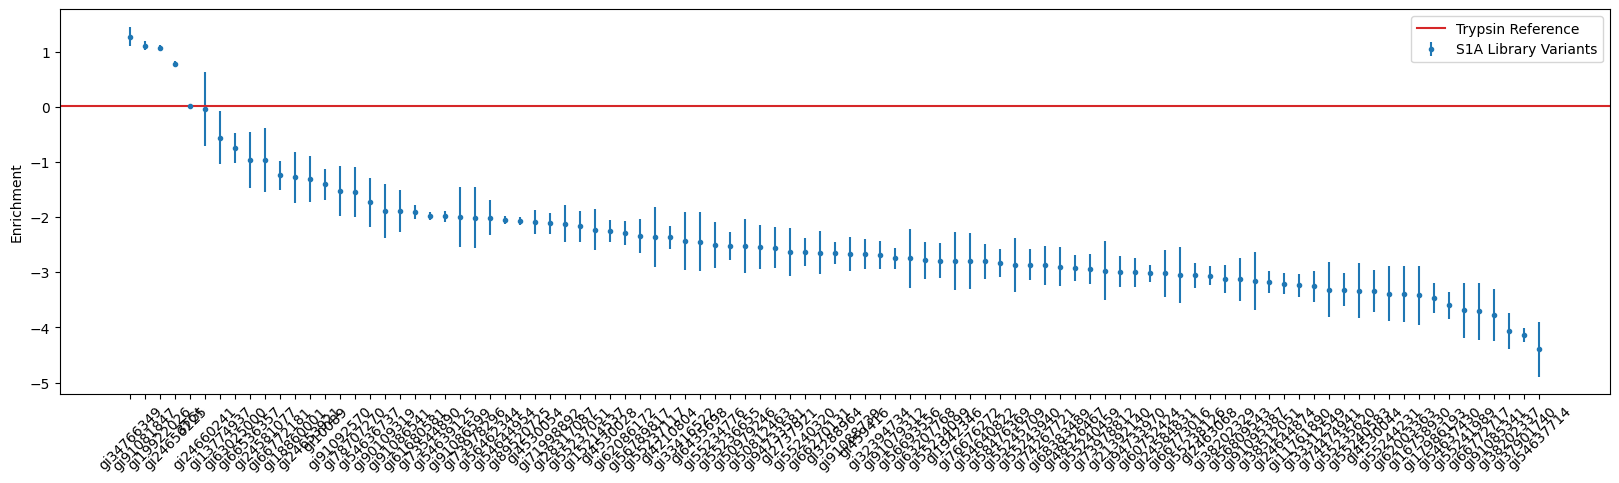

In [68]:
fig = plt.figure(figsize=(20, 5))
plt.errorbar(df_merge.index, df_merge.enrichment_means, df_merge.enrichment_stds, fmt='.', label='S1A Library Variants')
plt.xticks(rotation=45)
plt.ylabel('Enrichment')
plt.axhline(0.020692, color='tab:red', label='Trypsin Reference')
plt.legend()
plt.show()